In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
IMG_SHAPE = (32,32,3)
BATCH_SIZE = 512

# Size of the noise vector
noise_dim = 128

cifar10 = keras.datasets.cifar10
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
print(f"Number of examples: {len(train_images)}")
print(f"Shape of the images in the dataset: {train_images.shape[1:]}")

# Reshape each sample to (32,32,3) and normalize the pixel values in the [-1, 1] range
train_images = train_images.reshape(train_images.shape[0], *IMG_SHAPE).astype("float32")
train_images = (train_images - 127.5) / 127.5

Number of examples: 50000
Shape of the images in the dataset: (32, 32, 3)


In [3]:
def conv_block(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="same",
    use_bias=True,
    use_bn=False,
    use_dropout=False,
    drop_value=0.5,
):
    x = layers.Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)
    if use_bn:
        x = layers.BatchNormalization()(x)
    x = activation(x)
    if use_dropout:
        x = layers.Dropout(drop_value)(x)
    return x


def get_discriminator_model():
    img_input = layers.Input(shape=IMG_SHAPE)
    # Zero pad the input to make the input images size to (32, 32, 3).
    x = layers.ZeroPadding2D((2, 2))(img_input)
    x = conv_block(
        x,
        64,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        use_bias=True,
        activation=layers.LeakyReLU(0.2),
        use_dropout=False,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        128,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=True,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        256,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=True,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        512,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=False,
        drop_value=0.3,
    )

    x = layers.Flatten()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(1)(x)

    d_model = keras.models.Model(img_input, x, name="discriminator")
    return d_model


d_model = get_discriminator_model()
d_model.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 36, 36, 3)        0         
 2D)                                                             
                                                                 
 conv2d (Conv2D)             (None, 18, 18, 64)        4864      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 18, 18, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 9, 128)         204928    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 9, 9, 128)         0         
                                                     

In [4]:
def upsample_block(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(1, 1),
    up_size=(2, 2),
    padding="same",
    use_bn=False,
    use_bias=True,
    use_dropout=False,
    drop_value=0.3,
):
    x = layers.UpSampling2D(up_size)(x)
    x = layers.Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)

    if use_bn:
        x = layers.BatchNormalization()(x)

    if activation:
        x = activation(x)
    if use_dropout:
        x = layers.Dropout(drop_value)(x)
    return x


def get_generator_model():
    noise = layers.Input(shape=(noise_dim,))
    x = layers.Dense(4 * 4 * 256, use_bias=False)(noise)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Reshape((4, 4, 256))(x)
    x = upsample_block(
        x,
        128,
        layers.LeakyReLU(0.2),
        strides=(1, 1),
        use_bias=False,
        use_bn=True,
        padding="same",
        use_dropout=False,
    )
    x = upsample_block(
        x,
        64,
        layers.LeakyReLU(0.2),
        strides=(1, 1),
        use_bias=False,
        use_bn=True,
        padding="same",
        use_dropout=False,
    )
    x = upsample_block(
        x, 3, layers.Activation("tanh"), strides=(1, 1), use_bias=False, use_bn=True
    )
    # At this point, we have an output which has the same shape as the input, (32, 32, 1).
    # We will use a Cropping2D layer to make it (28, 28, 1).
    # x = layers.Cropping2D((2, 2))(x)
    # remove cropping layer?

    g_model = keras.models.Model(noise, x, name="generator")
    return g_model


g_model = get_generator_model()
g_model.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128)]             0         
                                                                 
 dense_1 (Dense)             (None, 4096)              524288    
                                                                 
 batch_normalization (BatchN  (None, 4096)             16384     
 ormalization)                                                   
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 4096)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 8, 8, 256)        0         
 )                                                       

In [5]:
class WGAN(keras.Model):
    def __init__(
        self,
        discriminator,
        generator,
        latent_dim,
        discriminator_extra_steps=3,
        gp_weight=10.0,
    ):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = discriminator_extra_steps
        self.gp_weight = gp_weight

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    def gradient_penalty(self, batch_size, real_images, fake_images):
        """Calculates the gradient penalty.

        This loss is calculated on an interpolated image
        and added to the discriminator loss.
        """
        # Get the interpolated image
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            pred = self.discriminator(interpolated, training=True)

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 3. Calculate the norm of the gradients.
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]

        # Get the batch size
        batch_size = tf.shape(real_images)[0]

        # For each batch, we are going to perform the
        # following steps as laid out in the original paper:
        # 1. Train the generator and get the generator loss
        # 2. Train the discriminator and get the discriminator loss
        # 3. Calculate the gradient penalty
        # 4. Multiply this gradient penalty with a constant weight factor
        # 5. Add the gradient penalty to the discriminator loss
        # 6. Return the generator and discriminator losses as a loss dictionary

        # Train the discriminator first. The original paper recommends training
        # the discriminator for `x` more steps (typically 5) as compared to
        # one step of the generator. Here we will train it for 3 extra steps
        # as compared to 5 to reduce the training time.
        for i in range(self.d_steps):
            # Get the latent vector
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )
            with tf.GradientTape() as tape:
                # Generate fake images from the latent vector
                fake_images = self.generator(random_latent_vectors, training=True)
                # Get the logits for the fake images
                fake_logits = self.discriminator(fake_images, training=True)
                # Get the logits for the real images
                real_logits = self.discriminator(real_images, training=True)

                # Calculate the discriminator loss using the fake and real image logits
                d_cost = self.d_loss_fn(real_img=real_logits, fake_img=fake_logits)
                # Calculate the gradient penalty
                gp = self.gradient_penalty(batch_size, real_images, fake_images)
                # Add the gradient penalty to the original discriminator loss
                d_loss = d_cost + gp * self.gp_weight

            # Get the gradients w.r.t the discriminator loss
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            # Update the weights of the discriminator using the discriminator optimizer
            self.d_optimizer.apply_gradients(
                zip(d_gradient, self.discriminator.trainable_variables)
            )

        # Train the generator
        # Get the latent vector
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            # Generate fake images using the generator
            generated_images = self.generator(random_latent_vectors, training=True)
            # Get the discriminator logits for fake images
            gen_img_logits = self.discriminator(generated_images, training=True)
            # Calculate the generator loss
            g_loss = self.g_loss_fn(gen_img_logits)

        # Get the gradients w.r.t the generator loss
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update the weights of the generator using the generator optimizer
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )
        return {"d_loss": d_loss, "g_loss": g_loss}

In [6]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=100, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.vmin = 0
        self.vmax = 1


    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images -= self.vmin
        generated_images /= (self.vmax - self.vmin)
        # Create a figure with 10 rows and 10 columns

            
        if (epoch % 50 == 1):
            fig, axes = plt.subplots(10,10, figsize=(10, 10))
            axes = axes.ravel()
            for i in range(self.num_img):
                img = keras.preprocessing.image.array_to_img(generated_images[i])
                axes[i].imshow(img)
                axes[i].axis("off")
            title = "Epoch " + str(epoch)
            plt.suptitle(title)
            if (epoch % 250 == 1):
              path = "./generated_img_" + title
              plt.savefig(path,dpi=300)
            plt.show()


        
        
            

# New Section

Epoch 1/300
98/98 [==============================] - 57s 493ms/step - d_loss: -7.3406 - g_loss: 21.8229
Epoch 2/300
98/98 [==============================] - ETA: 0s - d_loss: -4.1790 - g_loss: 12.7049

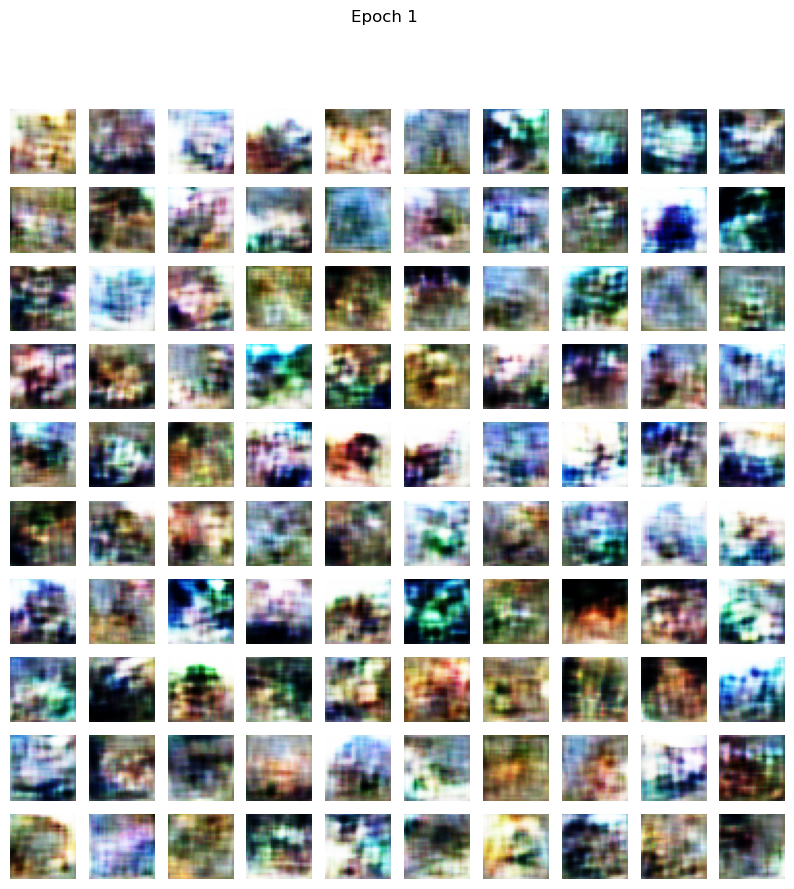

98/98 [==============================] - 50s 514ms/step - d_loss: -4.1810 - g_loss: 12.6020
Epoch 3/300
98/98 [==============================] - 48s 486ms/step - d_loss: -3.7075 - g_loss: 5.0171
Epoch 4/300
98/98 [==============================] - 48s 487ms/step - d_loss: -3.4194 - g_loss: 1.5335
Epoch 5/300
98/98 [==============================] - 48s 488ms/step - d_loss: -3.0173 - g_loss: -6.4131
Epoch 6/300
98/98 [==============================] - 48s 488ms/step - d_loss: -2.9612 - g_loss: -1.9092
Epoch 7/300
98/98 [==============================] - 48s 488ms/step - d_loss: -2.9240 - g_loss: -1.0536
Epoch 8/300
98/98 [==============================] - 48s 488ms/step - d_loss: -2.8378 - g_loss: -5.3020
Epoch 9/300
98/98 [==============================] - 48s 488ms/step - d_loss: -2.8439 - g_loss: -2.2552
Epoch 10/300
98/98 [==============================] - 48s 488ms/step - d_loss: -2.7490 - g_loss: -3.3330
Epoch 11/300
98/98 [==============================] - 48s 488ms/step - d_loss

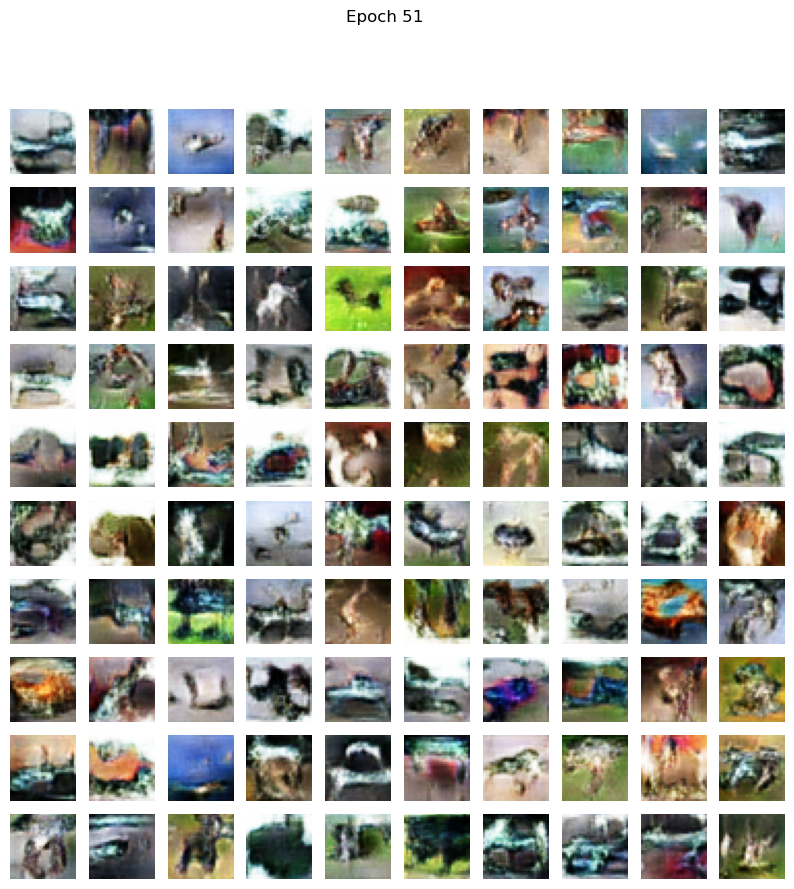

98/98 [==============================] - 47s 478ms/step - d_loss: -1.5237 - g_loss: 0.2351
Epoch 53/300
98/98 [==============================] - 45s 454ms/step - d_loss: -1.5084 - g_loss: -0.9236
Epoch 54/300
98/98 [==============================] - 45s 454ms/step - d_loss: -1.5153 - g_loss: -1.2109
Epoch 55/300
98/98 [==============================] - 45s 454ms/step - d_loss: -1.5129 - g_loss: 0.2403
Epoch 56/300
98/98 [==============================] - 45s 454ms/step - d_loss: -1.5605 - g_loss: 1.3756
Epoch 57/300
98/98 [==============================] - 45s 454ms/step - d_loss: -1.4074 - g_loss: -1.5645
Epoch 58/300
98/98 [==============================] - 45s 454ms/step - d_loss: -1.4712 - g_loss: -2.6132
Epoch 59/300
98/98 [==============================] - 45s 454ms/step - d_loss: -1.4775 - g_loss: 3.8631
Epoch 60/300
98/98 [==============================] - 44s 454ms/step - d_loss: -1.5548 - g_loss: 0.8922
Epoch 61/300
98/98 [==============================] - 44s 454ms/step - d_

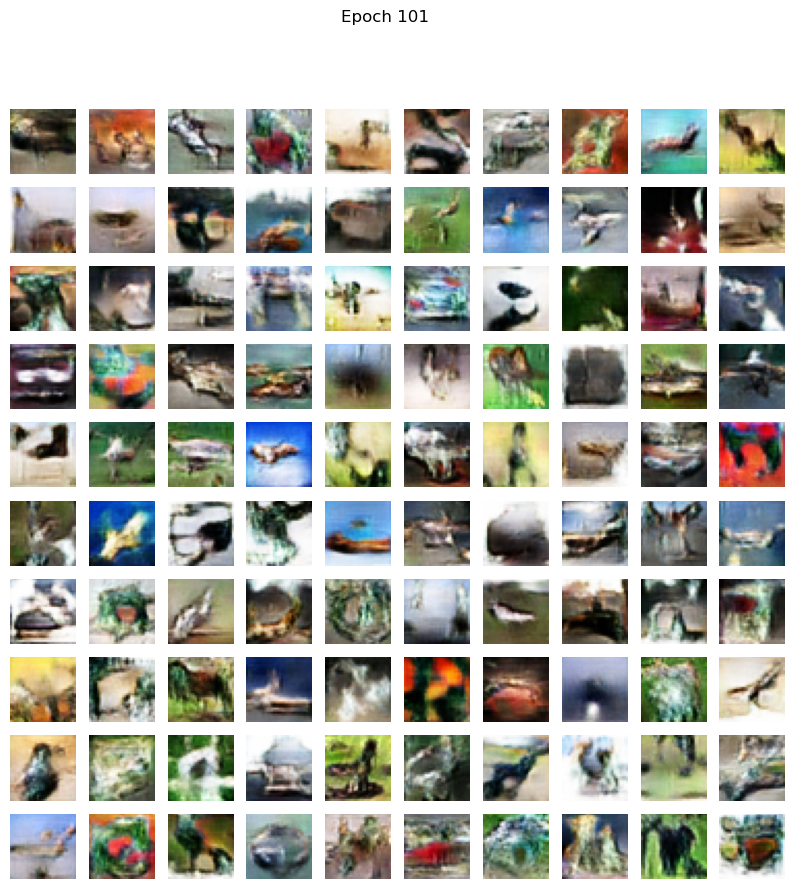

98/98 [==============================] - 47s 482ms/step - d_loss: -1.3120 - g_loss: 1.8494
Epoch 103/300
98/98 [==============================] - 46s 466ms/step - d_loss: -1.2848 - g_loss: 1.4237
Epoch 104/300
98/98 [==============================] - 46s 466ms/step - d_loss: -1.3256 - g_loss: 1.1203
Epoch 105/300
98/98 [==============================] - 45s 455ms/step - d_loss: -1.2511 - g_loss: 1.0639
Epoch 106/300
98/98 [==============================] - 44s 453ms/step - d_loss: -1.2916 - g_loss: -0.7054
Epoch 107/300
98/98 [==============================] - 45s 455ms/step - d_loss: -1.1969 - g_loss: 0.4681
Epoch 108/300
98/98 [==============================] - 45s 460ms/step - d_loss: -1.2933 - g_loss: 1.3242
Epoch 109/300
98/98 [==============================] - 45s 460ms/step - d_loss: -1.2012 - g_loss: 2.2679
Epoch 110/300
98/98 [==============================] - 45s 460ms/step - d_loss: -1.3089 - g_loss: 0.6502
Epoch 111/300
98/98 [==============================] - 45s 460ms/ste

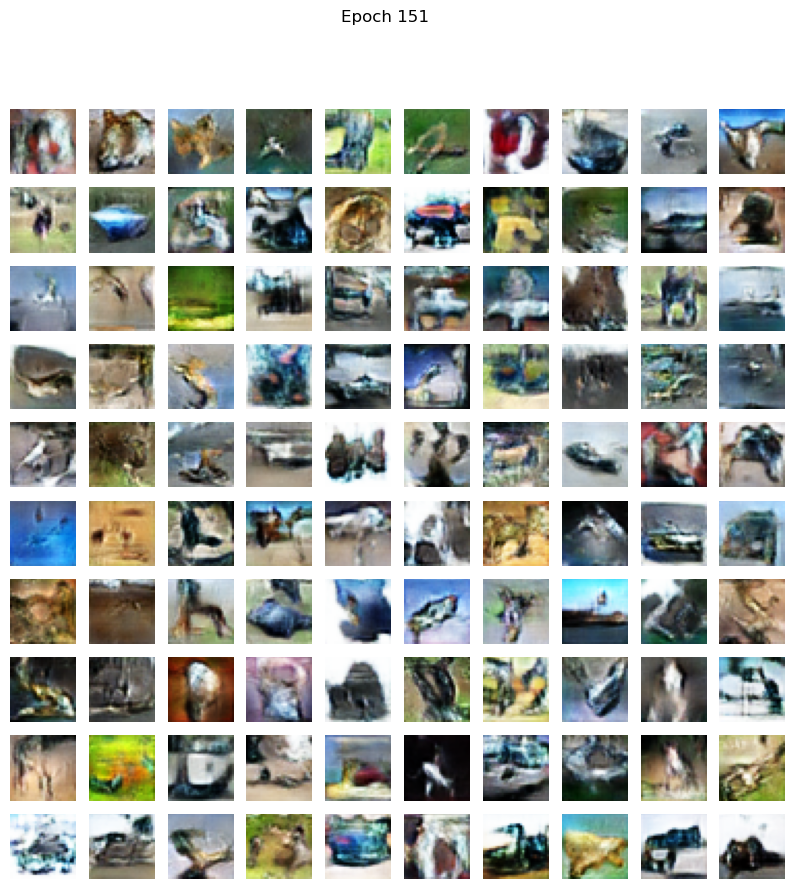

98/98 [==============================] - 48s 488ms/step - d_loss: -1.1581 - g_loss: 2.6190
Epoch 153/300
98/98 [==============================] - 46s 466ms/step - d_loss: -1.1354 - g_loss: 2.7578
Epoch 154/300
98/98 [==============================] - 46s 466ms/step - d_loss: -1.1498 - g_loss: 3.7828
Epoch 155/300
98/98 [==============================] - 46s 466ms/step - d_loss: -1.1098 - g_loss: 3.3301
Epoch 156/300
98/98 [==============================] - 45s 460ms/step - d_loss: -1.1638 - g_loss: 2.1495
Epoch 157/300
98/98 [==============================] - 45s 464ms/step - d_loss: -1.1111 - g_loss: 0.8604
Epoch 158/300
98/98 [==============================] - 46s 466ms/step - d_loss: -1.2022 - g_loss: 1.7162
Epoch 159/300
98/98 [==============================] - 46s 465ms/step - d_loss: -1.1373 - g_loss: 2.4267
Epoch 160/300
98/98 [==============================] - 46s 466ms/step - d_loss: -1.1175 - g_loss: 2.6139
Epoch 161/300
98/98 [==============================] - 46s 466ms/step

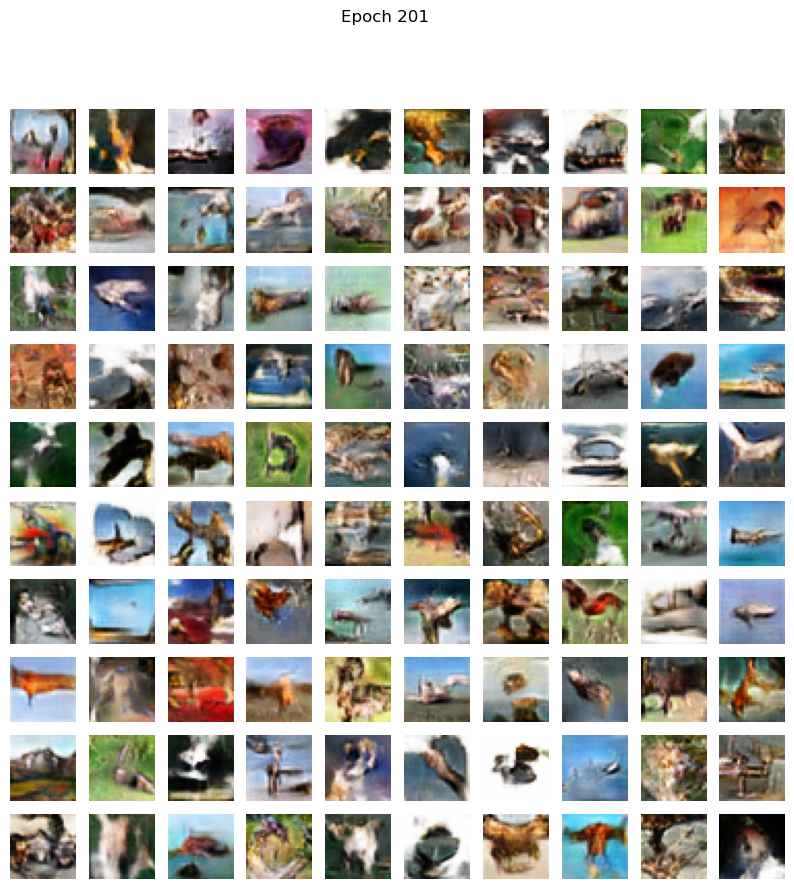

98/98 [==============================] - 47s 480ms/step - d_loss: -1.0251 - g_loss: 2.9691
Epoch 203/300
98/98 [==============================] - 44s 452ms/step - d_loss: -1.0047 - g_loss: 2.4707
Epoch 204/300
98/98 [==============================] - 44s 453ms/step - d_loss: -1.0519 - g_loss: 2.5521
Epoch 205/300
98/98 [==============================] - 44s 453ms/step - d_loss: -0.9330 - g_loss: 1.7011
Epoch 206/300
98/98 [==============================] - 44s 453ms/step - d_loss: -1.0218 - g_loss: 1.6597
Epoch 207/300
98/98 [==============================] - 44s 453ms/step - d_loss: -0.9699 - g_loss: 1.5330
Epoch 208/300
98/98 [==============================] - 44s 453ms/step - d_loss: -1.0143 - g_loss: 1.2662
Epoch 209/300
98/98 [==============================] - 44s 453ms/step - d_loss: -0.9972 - g_loss: 0.4574
Epoch 210/300
98/98 [==============================] - 44s 453ms/step - d_loss: -1.0503 - g_loss: 0.5067
Epoch 211/300
98/98 [==============================] - 44s 453ms/step

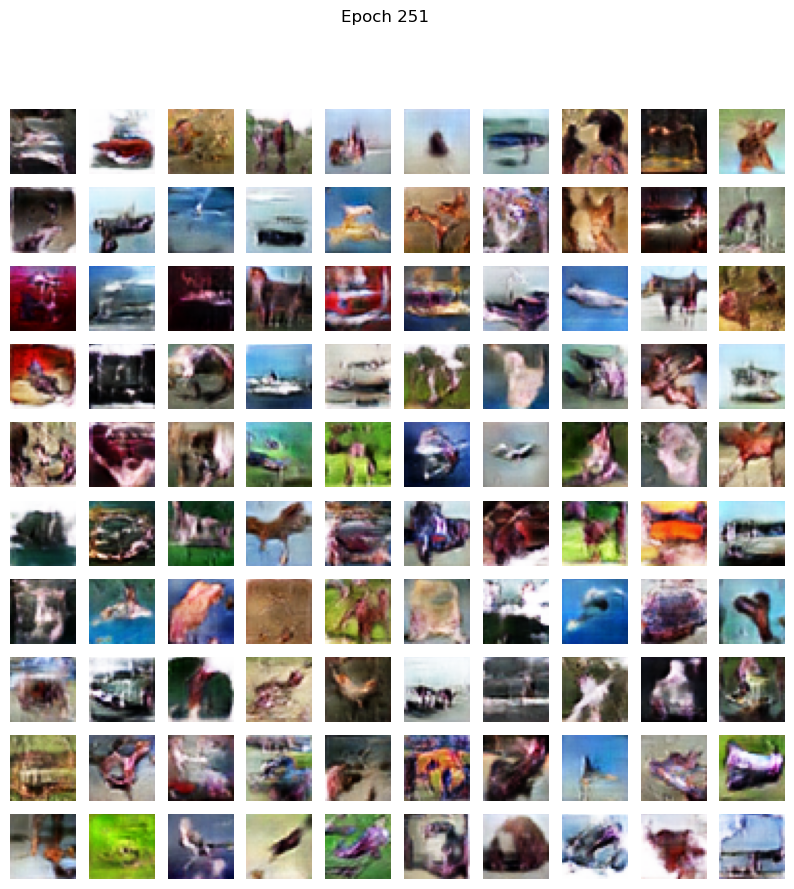

98/98 [==============================] - 47s 483ms/step - d_loss: -0.9694 - g_loss: 1.6683
Epoch 253/300
98/98 [==============================] - 44s 452ms/step - d_loss: -0.9292 - g_loss: 0.7109
Epoch 254/300
98/98 [==============================] - 44s 452ms/step - d_loss: -0.9489 - g_loss: 1.2075
Epoch 255/300
98/98 [==============================] - 44s 453ms/step - d_loss: -0.8722 - g_loss: 1.7124
Epoch 256/300
98/98 [==============================] - 44s 453ms/step - d_loss: -0.9398 - g_loss: 0.4124
Epoch 257/300
98/98 [==============================] - 44s 453ms/step - d_loss: -0.9371 - g_loss: 2.0218
Epoch 258/300
98/98 [==============================] - 44s 453ms/step - d_loss: -0.9235 - g_loss: 1.3930
Epoch 259/300
98/98 [==============================] - 44s 453ms/step - d_loss: -0.9945 - g_loss: 2.2995
Epoch 260/300
98/98 [==============================] - 44s 453ms/step - d_loss: -0.9156 - g_loss: 2.4820
Epoch 261/300
98/98 [==============================] - 44s 453ms/step

In [7]:
# Instantiate the optimizer for both networks
# (learning_rate=0.0002, beta_1=0.5 are recommended)
generator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)
discriminator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)

# Define the loss functions for the discriminator,
# which should be (fake_loss - real_loss).
# We will add the gradient penalty later to this loss function.
def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss


# Define the loss functions for the generator.
def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)


# Set the number of epochs for trainining.
epochs = 300

# Instantiate the customer `GANMonitor` Keras callback.
cbk = GANMonitor(num_img=100, latent_dim=noise_dim)

# Get the wgan model
wgan = WGAN(
    discriminator=d_model,
    generator=g_model,
    latent_dim=noise_dim,
    discriminator_extra_steps=3,
)

# Compile the wgan model
wgan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss,
)

# Start training
hist = wgan.fit(train_images, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

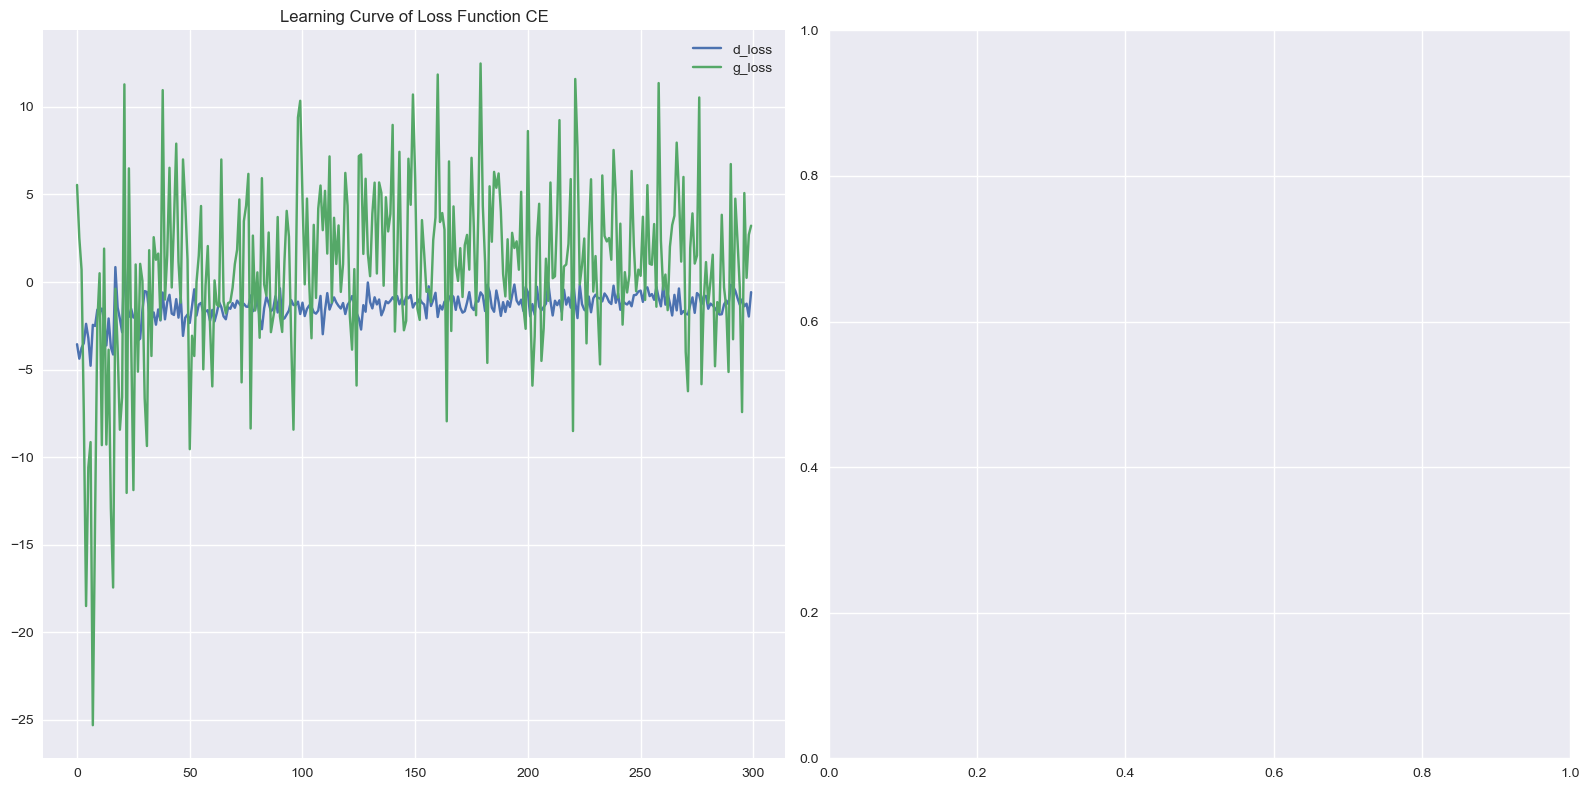

In [8]:
# story history object into dataframe
hist_df = pd.DataFrame(hist.history)

# using pandas dataframe to plot out learning curve
with plt.style.context('seaborn'):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), tight_layout=True)
    hist_df.loc[:, ["d_loss", 'g_loss']].plot(ax=ax1, title=r'Learning Curve of Loss Function CE')
    plt.show()


In [9]:
tf.keras.models.save_model(d_model , "./discriminator_wgan4.h5")

In [10]:
tf.keras.models.save_model(g_model , "./generator_wgan4.h5")